The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.618438   0.33819613 0.02701653]
Gaussian Process Train R^2 0.9999714986662341
Gaussian Process Valid R^2 0.9985786980235941
Training set loss: 0.0010014196475626334
Testing Set Loss 0.0390885663548072
Gaussian Proccess Training Field Reconstruction Loss: 0.0005887637712732738
Gaussian Proccess Validation Field Reconstruction Loss: 0.0005580441322926261
PCA Training Field Reconstruction Loss 0.0005880702673622193
PCA Validation Field Reconstruction Loss 0.0005309744880025933


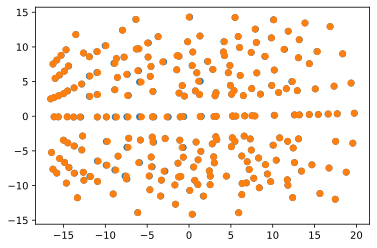

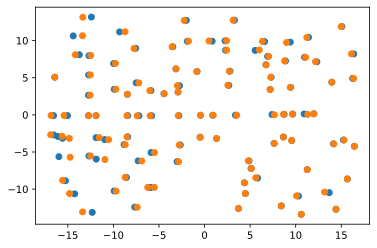

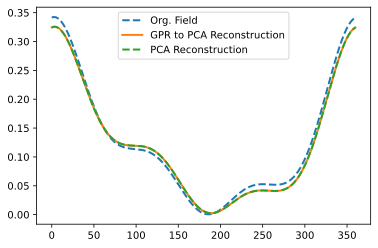

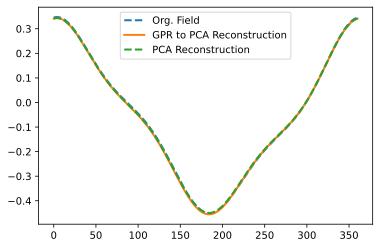

In [86]:
## Make Training Validation Set Split

from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from ssapp import Utils
from torch.utils.data.dataloader import DataLoader
from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
import numpy as np

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2


dataset = PatchAntennaDataset()

train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)

train_loader = DataLoader(train_data,batch_size=len(train_data),shuffle=True)
test_loader = DataLoader(test_data,batch_size=len(test_data),shuffle=True)

TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(test_loader))


pca = PCA(n_components=3)
pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
print(pca.explained_variance_ratio_)
pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))


PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)


gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 
print('Gaussian Process Train R^2',gpr.score(TRAIN_PARAMS, pca_train))
print('Gaussian Process Valid R^2',gpr.score(TEST_PARAMS, pca_val))

TRAIN_LOSS = metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train)
TEST_LOSS = metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val)

print('Training set loss:', TRAIN_LOSS)
print('Testing Set Loss', TEST_LOSS)


PCA_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten())
PCA_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten())


## Loss in reconstruction
GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

GPR_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten())
GPR_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten())




print('Gaussian Proccess Training Field Reconstruction Loss:',GPR_TRAIN_RECONSTRUCTION_LOSS)
print('Gaussian Proccess Validation Field Reconstruction Loss:',GPR_TEST_RECONSTRUCTION_LOSS)
print('PCA Training Field Reconstruction Loss',PCA_TRAIN_RECONSTRUCTION_LOSS)
print('PCA Validation Field Reconstruction Loss',PCA_TEST_RECONSTRUCTION_LOSS)


# Show Training Latent Space

plt.figure()
plt.scatter(pca_train[:,0],pca_train[:,1])
plt.scatter(gpr.predict(TRAIN_PARAMS)[:,0],gpr.predict(TRAIN_PARAMS)[:,1])

# Show Validation Latent Space

plt.figure()
plt.scatter(pca_val[:,0],pca_val[:,1])
plt.scatter(gpr.predict(TEST_PARAMS)[:,0],gpr.predict(TEST_PARAMS)[:,1])



train_sample = np.random.randint(0,len(train_data)-1)
test_sample = np.random.randint(0,len(test_data)-1)
# Plot Training Field Reconstruction
plt.figure()
plt.plot(TRAIN_FIELDS[train_sample,:,1,1], label = 'Org. Field',linestyle =  '--')
plt.plot(GPR_TRAIN_RECONSTRUCTED_FIELD[train_sample,:,1,1],label = 'GPR to PCA Reconstruction')
plt.plot(PCA_TRAIN_RECONSTRUCTED_FIELD[train_sample,:,1,1],label = 'PCA Reconstruction',linestyle =  '--')
plt.legend()

# Plot Validation Field Reconstruction

plt.figure()
plt.plot(TEST_FIELDS[test_sample,:,1,1], label = 'Org. Field',linestyle =  '--')
plt.plot(GPR_TEST_RECONSTRUCTED_FIELD[test_sample,:,1,1],label = 'GPR to PCA Reconstruction')
plt.plot(PCA_TEST_RECONSTRUCTED_FIELD[test_sample,:,1,1],label = 'PCA Reconstruction',linestyle =  '--')
plt.legend()




In [92]:
## Gaussian Process Loss as functino of PCA Components

HIGH_NUM_PCA = 20

Number_PCAs = []

sweep_info = {
        'PCR Train Rec. Loss': [],
        'PCR Validation Rec. Loss': [],
        'GP Train Latent Loss': [],
        'GP Validation Latent Loss': [],
        'GP-PCA Train Rec. Loss': [],
        'GP-PCA Validation Rec. Loss': [],
        'LR-PCA Train Rec. Loss': [],
        'LR-PCA Validation Rec. Loss': []
        
        }

for num_pca in range(1,HIGH_NUM_PCA+1):

    Number_PCAs.append(num_pca)
    pca = PCA(n_components=num_pca)
    pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
    pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))

    PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
    PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)

    gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 

    sweep_info['GP Train Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train))
    sweep_info['GP Validation Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val))

    sweep_info['PCR Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['PCR Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten()))

    ## Loss in reconstruction
    GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    LR = LinearRegression().fit(TRAIN_PARAMS, pca_train) 

    LR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    LR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    sweep_info['GP-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['GP-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten()))

    sweep_info['LR-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), LR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['LR-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), LR_TEST_RECONSTRUCTED_FIELD.flatten()))




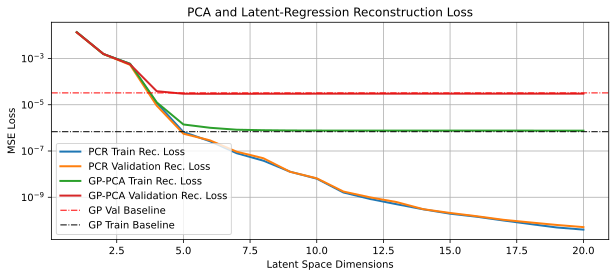

In [105]:
plt.figure(figsize = (10,4))
plt.semilogy(Number_PCAs,sweep_info['PCR Train Rec. Loss'],label ='PCR Train Rec. Loss' )
plt.semilogy(Number_PCAs,sweep_info['PCR Validation Rec. Loss'],label='PCR Validation Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Train Rec. Loss'],label = 'GP-PCA Train Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Validation Rec. Loss'],label = 'GP-PCA Validation Rec. Loss')
plt.axhline(3.2447262845002656e-05,color = 'red',linestyle = '-.',linewidth = 1,label = 'GP Val Baseline')
plt.axhline(6.84051583744767e-07,color = 'black',linestyle = '-.',linewidth = 1,label = 'GP Train Baseline')
plt.legend()
plt.xlabel('Latent Space Dimensions')
plt.ylabel('MSE Loss')
plt.title('PCA and Latent-Regression Reconstruction Loss')
plt.grid(True)

In [67]:
print(pca_train.shape)

(240, 40)


In [106]:
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
import pandas as pd 

benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'Linear Reg.':LinearRegression(),
                    'Ridge Reg.': Ridge()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'MAPE':metrics.mean_absolute_percentage_error,
                'R Squared':metrics.r2_score,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score}


test_loss_dict = dict.fromkeys(test_metrics.keys(),[])

test_df = pd.DataFrame()

for name,model in benchmark_models.items():

    print(name)
    model.fit(TRAIN_PARAMS, TRAIN_FIELDS.reshape(len(TRAIN_FIELDS),-1))

    for test_name,test_metric in test_metrics.items():
        test_loss_dict[test_name].append()
        print(test_metric(TRAIN_FIELDS.flatten(),model.predict(TRAIN_PARAMS).flatten()))
        print('Valid')
        print(test_metric(TEST_FIELDS.flatten(),model.predict(TEST_PARAMS).flatten()))



Gaus. Proc.
Mean Squared
Test
7.598551945139721e-07
Valid
3.004054305985123e-05
MAPE
Test
0.03878235108765916
Valid
0.13771511217823348
R Squared
Test
0.9999970596498121
Valid
0.9998837105074523
Max Error
Test
0.012063240758680482
Valid
0.0748862032691449
Explained Variance
Test
0.9999970596498121
Valid
0.999883743442572
Linear Reg.
Mean Squared
Test
0.002280886552543672
Valid
0.002231271173976546
MAPE
Test
2.0349087130092007
Valid
0.8848837908831341
R Squared
Test
0.9911738377893432
Valid
0.9913625598564855
Max Error
Test
0.4089090026437714
Valid
0.36056258147107545
Explained Variance
Test
0.991173837789407
Valid
0.9913686647996138
Ridge Reg.
Mean Squared
Test
0.006911420957550602
Valid
0.006355381403573102
MAPE
Test
2.2358391169228025
Valid
1.0798515613120714
R Squared
Test
0.9732554333272538
Valid
0.9753977790316107
Max Error
Test
0.5328030770850681
Valid
0.5596854254250112
Explained Variance
Test
0.9732554333272538
Valid
0.9754040352709437


In [115]:
[[x+y for y in ['_Val','_Test']] for x in test_metrics.keys()]

[['Mean Squared_Val', 'Mean Squared_Test'],
 ['MAPE_Val', 'MAPE_Test'],
 ['R Squared_Val', 'R Squared_Test'],
 ['Max Error_Val', 'Max Error_Test'],
 ['Explained Variance_Val', 'Explained Variance_Test']]